In [24]:
import pandas as pd
import numpy as np
import glob, shutil
import cv2
import matplotlib.pyplot as plt

**SIIM Pneumothorax Dataset Analysis**

Positive cases: 245
Negative cases: 897
Histogram of size of disease


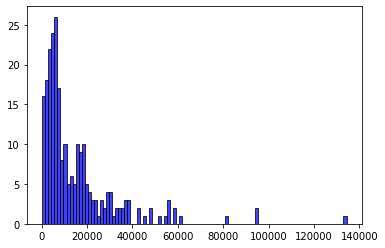

In [38]:
mask_paths = glob.glob("gaze-image-dataset/*/ground_truth/*")
gaze_paths = glob.glob("gaze-image-dataset/gaze_images/*")

mask_id_to_mask_path = { f.split("\\")[-1].replace(".jpg", "") : f for f in mask_paths }

disease_size_list = []
for mask_path in mask_paths:
    mask = cv2.imread(mask_path, cv2.COLOR_BGR2GRAY) / 255
    if mask.max() > 0:
        disease_size_list.append(mask.sum())

disease_size_list = np.array(disease_size_list)

print(f"Positive cases: {len(disease_size_list)}")
print(f"Negative cases: {len(mask_paths) - len(disease_size_list)}")

print("Histogram of size of disease")
plt.hist(disease_size_list, bins=100, alpha=0.75, color='blue', edgecolor='black')
plt.show()

In [27]:
# Dice Coefficient
def dice_coefficient(A, B):
    intersection = np.sum(A * B)
    return 2 * intersection / (np.sum(A) + np.sum(B))

# Intersection over Union (IoU)
def iou(A, B):
    intersection = np.sum(A * B)
    union = np.sum(A) + np.sum(B) - intersection
    return intersection / union

# How much of the mask is gaze covering
def intersection_over_mask(A, B):
    intersection = np.sum(A * B)
    return intersection / np.sum(A)

def heatmap_spread(A):
    return np.sum(A / (1024**2))

def make_heatmaps(gaze_seqs, num_patches=8, normalize_heatmaps=False):
    all_grids = np.zeros(
        (len(gaze_seqs), 1, num_patches, num_patches), dtype=np.float32
    )
    for ndx, gaze_seq in enumerate(gaze_seqs):
        # loop through gaze seq and increment # of visits to each patch
        for (x, y, t) in gaze_seq:
            # make sure if x or y are > 1 then they are 1
            x, y = np.clip([x, y], 0.0, 0.999)
            patch_x, patch_y = int(x * num_patches), int(y * num_patches)
            all_grids[ndx, 0, patch_x, patch_y] += t
        if normalize_heatmaps:
            # Destroy total time information, as a diagnostic
            all_grids[ndx] /= np.sum(all_grids[ndx])
    return all_grids

In [42]:
# for positive cases, we compute similarity metrics between mask and gaze
# for negative cases, we compute size and spread of gaze

dice_scores = []
iou_scores = []
intersection_over_mask_scores = []
heatmap_spread_scores_positives = []
heatmap_spread_scores_negatives = []
for gaze_path in gaze_paths:
    mask = cv2.imread(mask_id_to_mask_path[gaze_path.split("\\")[-1].replace(".jpg", "")], cv2.COLOR_BGR2GRAY).astype(np.float64) / 255
    gaze = cv2.imread(gaze_path, cv2.COLOR_BGR2GRAY).astype(np.float64)
    # print(gaze)
    # make_heatmaps([gaze]).shape
    # break
    gaze_normalised = gaze / np.max(gaze)
    if mask.max() > 0:
        dice_scores.append(dice_coefficient(mask, gaze_normalised))
        iou_scores.append(iou(mask, gaze_normalised))
        intersection_over_mask_scores.append(intersection_over_mask(mask, gaze_normalised))
        heatmap_spread_scores_positives.append(heatmap_spread(gaze))
    else:
        heatmap_spread_scores_negatives.append(heatmap_spread(gaze))

print(f"Mean dice score between mask and gaze: {np.array(dice_scores).mean()}")
print(f"Mean iou score between mask and gaze: {np.array(iou_scores).mean()}")
print(f"Mean intersection over mask score between mask and gaze: {np.array(intersection_over_mask_scores).mean()}")
print(f"Mean heatmap spread score in positive cases: {np.array(heatmap_spread_scores_positives).mean()}")
print(f"Mean heatmap spread score in negative cases: {np.array(heatmap_spread_scores_negatives).mean()}")

Mean dice score between mask and gaze: 0.11528009229090119
Mean iou score between mask and gaze: 0.0639190082612748
Mean intersection over mask score between mask and gaze: 0.4378861633752245
Mean heatmap spread score in positive cases: 1.10467302275867
Mean heatmap spread score in negative cases: 0.7536436891427948


**TUFTS Dental Dataset Analysis**